In [ ]:
import numpy as np
import cv2
import torch
from torchvision import transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Loading pre-trained torchvision.models.detection.keypointrcnn_resnet50_fpn model.

In [ ]:
model = keypointrcnn_resnet50_fpn(weights='DEFAULT').to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 120MB/s]


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

## 2. Keypoints list:

In [ ]:
keypoints = [
    'nose','left_eye','right_eye',
    'left_ear','right_ear','left_shoulder',
    'right_shoulder','left_elbow','right_elbow',
    'left_wrist','right_wrist','left_hip',
    'right_hip','left_knee', 'right_knee',
    'left_ankle','right_ankle'
]

## 3. Loading running person image and its transformation to model format.

In [ ]:
! wget https://lms-cdn.skillfactory.ru/assets/courseware/v1/916f2b30ed417a727ebf512c413d20dd/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/dspr_cv_u1_diploma_spr1_3_1.png -O running_girl.png

--2024-02-05 19:56:22--  https://lms-cdn.skillfactory.ru/assets/courseware/v1/916f2b30ed417a727ebf512c413d20dd/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/dspr_cv_u1_diploma_spr1_3_1.png
Resolving lms-cdn.skillfactory.ru (lms-cdn.skillfactory.ru)... 193.17.93.93, 2a11:27c0::93
Connecting to lms-cdn.skillfactory.ru (lms-cdn.skillfactory.ru)|193.17.93.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1478798 (1.4M) [image/png]
Saving to: ‘running_girl.png’

running_girl.png    100%[===================>]   1.41M  1.51MB/s    in 0.9s    

2024-02-05 19:56:24 (1.51 MB/s) - ‘running_girl.png’ saved [1478798/1478798]



In [ ]:
image = cv2.imread('running_girl.png')
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).to(device)

## 4. Inference for the image to obtain keypoints.

In [ ]:
with torch.no_grad():
    predictions = model([image_tensor])

## 5. Function to draw keypoints:

In [ ]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap("rainbow")
    # create a copy of the image
    img_copy = img.copy()
    # pick a set of N color-ids from the spectrum
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # iterate for every person detected
    for person_id in range(len(all_keypoints)):
        # check the confidence score of the detected person
        if confs[person_id] > conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]
            # grab the keypoint-scores for the keypoints
            scores = all_scores[person_id, ...]
            # iterate for every keypoint-score
            for kp in range(len(scores)):
                # check the confidence score of detected keypoint
                if scores[kp] > keypoint_threshold:
                    # convert the keypoint float-array to a list of integers
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    # pick the color at the specific color-id
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # draw a circle over the keypoint location
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

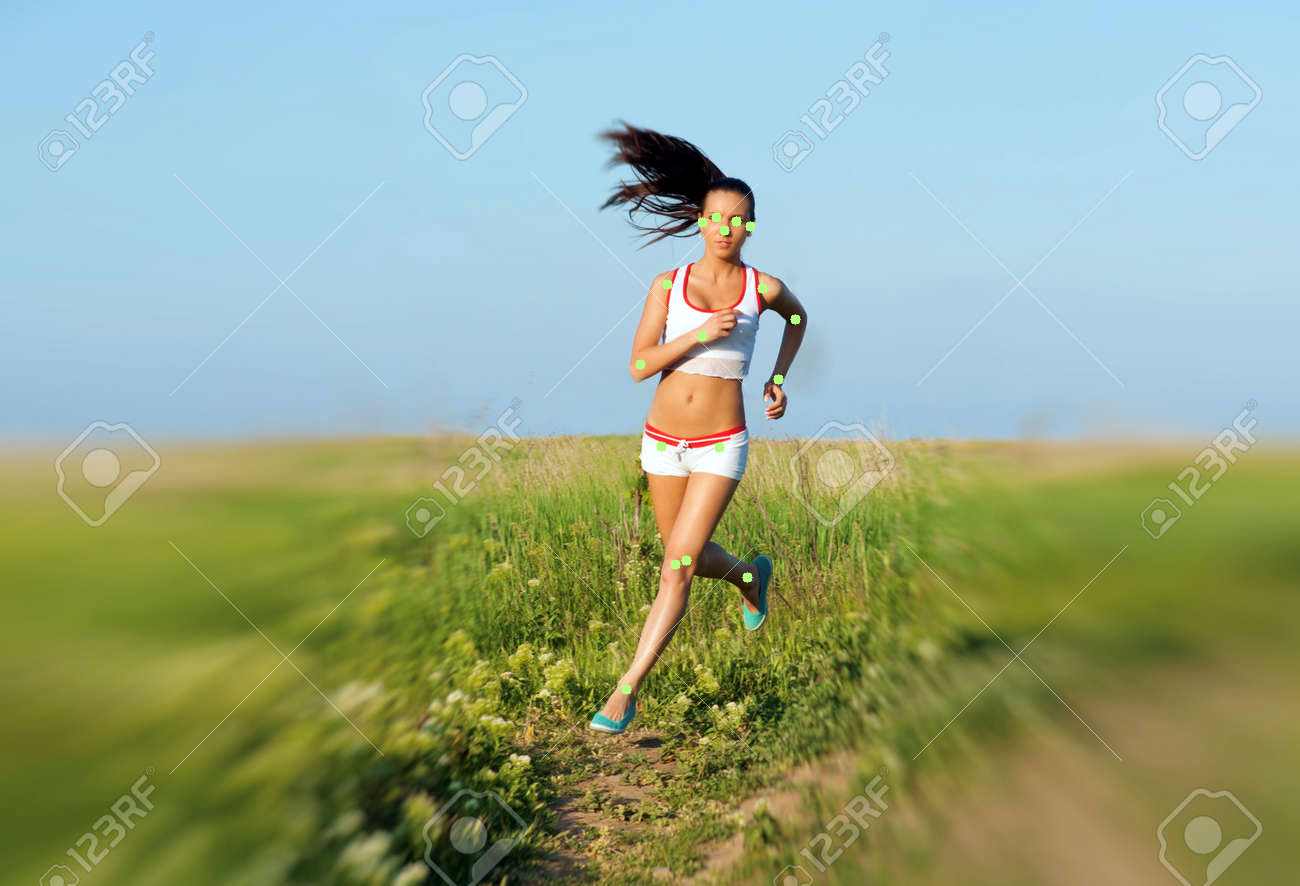

In [ ]:
boxes, labels, confs, all_keypoints, all_scores = [x.cpu() for x in predictions[0].values()]
image_with_kps = draw_keypoints_per_person(image, all_keypoints, all_scores, confs)
cv2_imshow(image_with_kps)

## 6. Function to create limb list of the person:

In [ ]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints)

## 7. Function to draw skeleton.

In [ ]:
def draw_limbs(
    img, limbs, all_keypoints, all_scores, confs,
    keypoint_threshold=2, conf_threshold=0.9
):
    img = img.copy()

    # color sequence
    cmap = plt.get_cmap('jet')
    color_ids = (np.linspace(0, 255, len(all_keypoints) + 2)
                 .astype(int).tolist()[1:-1])

    # for each instance
    for person_id, conf in enumerate(confs):
        if conf > conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            color = tuple(np.asarray(cmap(color_ids[person_id])[:-1]) * 255)

            # for each keepoint
            for kp_id, score in enumerate(scores):
                if score > keypoint_threshold:
                    keypoint = tuple(map(int, keypoints[kp_id, :2]))
                    cv2.circle(img, keypoint, 5, color, -1)

            # for each limb
            for limb in limbs:
                kp1_id,  kp2_id = limb[0], limb[1]
                if (scores[kp1_id] > keypoint_threshold
                    and  scores[kp2_id] > keypoint_threshold
                ):
                    keypoint1 = tuple(map(int, keypoints[kp1_id, :2]))
                    keypoint2 = tuple(map(int, keypoints[kp2_id, :2]))
                    cv2.line(img, keypoint1, keypoint2, color, thickness=2)

    return img

## 8. Drawing skeleton on the image.

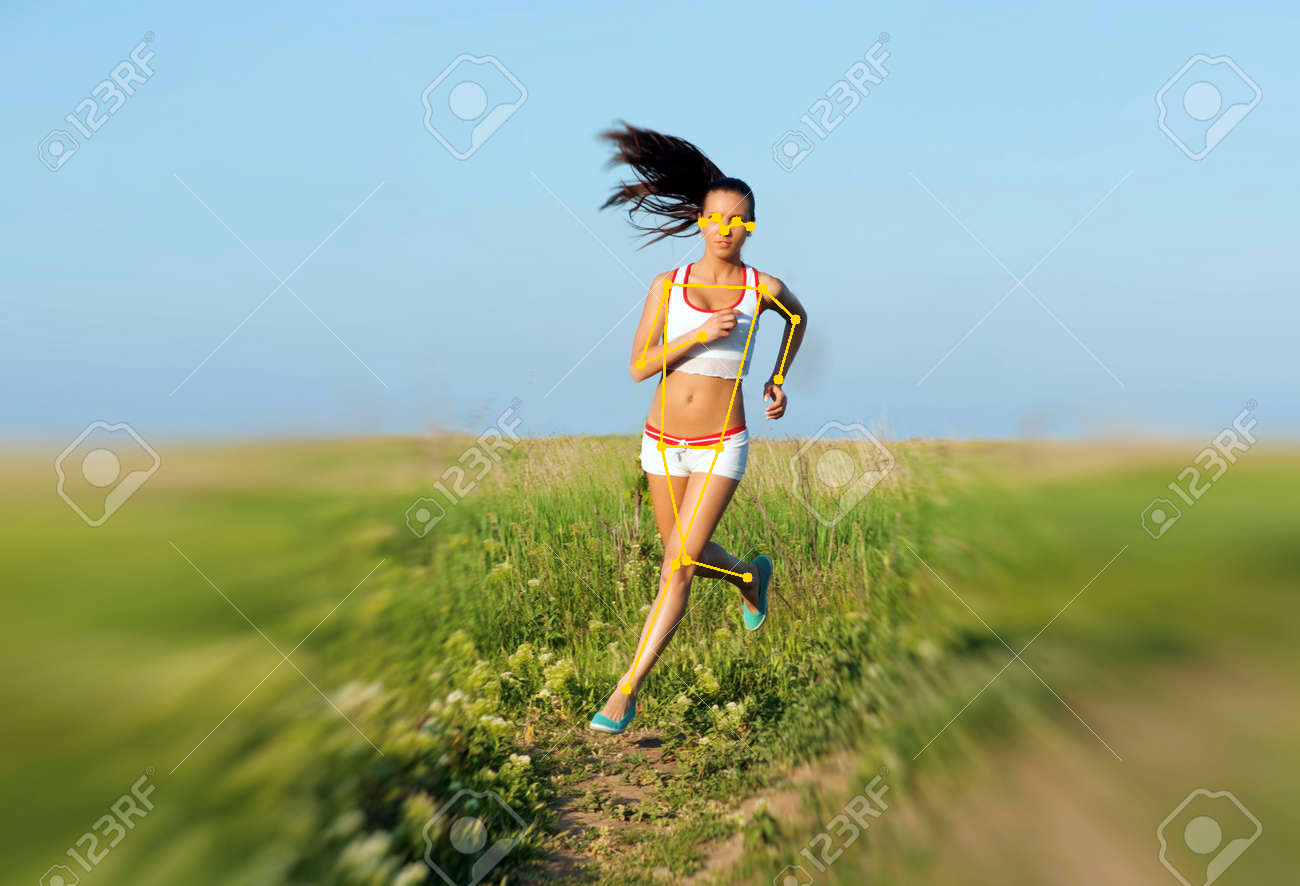

In [ ]:
image_with_limbs = draw_limbs(image, limbs, all_keypoints, all_scores, confs)

cv2_imshow(image_with_limbs);